# Phase 1: Data Understanding & Preparation

## 1️⃣ Import Libraries



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2️⃣ Load Data from Excel (Multiple Branch Sheets)

The ERP export contains branch-level sheets, which mirrors real dealership reporting systems.

In [4]:
sheets = pd.read_excel("SALE.xlsx",
    sheet_name=None
)

pl = sheets['PALAYAM']
mh = sheets['MUTTATHARA']

## 3️⃣ Initial Data Inspection


Nulls are common in ERP data due to optional fields, policy jobs, and mixed billing structures.

In [5]:
pl.head()
pl.info()
pl.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44061 entries, 0 to 44060
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Branch                  40796 non-null  object 
 1   Technician Name         40795 non-null  object 
 2   Vehicle Type            44060 non-null  object 
 3   Item Code               44060 non-null  object 
 4   Item Name               44060 non-null  object 
 5   Item Group              44060 non-null  object 
 6   Invoice                 44060 non-null  object 
 7   Posting Date            44060 non-null  object 
 8   Customer Group          44060 non-null  object 
 9   Customer                44060 non-null  object 
 10  Customer Name           44060 non-null  object 
 11  Receivable Account      44060 non-null  object 
 12  Company                 44060 non-null  object 
 13  Income Account          44060 non-null  object 
 14  Cost Center             44060 non-null

,0
Branch,3265
Technician Name,3266
Vehicle Type,1
Item Code,1
Item Name,1
Item Group,1
Invoice,1
Posting Date,1
Customer Group,1
Customer,1


## 4️⃣ Handle Missing Values


For numeric demand analysis, missing quantities or amounts are treated as zero to avoid breaking aggregations.

In [6]:
pl.fillna(0, inplace=True)

## 5️⃣ Identify & Remove Invoice TOTAL Rows (Very Important)

### 🔍 Problem Observation

The dataset contains invoice-level TOTAL rows where stock quantity and amount represent invoice summaries, not actual items.
These rows cause extreme outliers and double-counting.

### 📌 Business Insight
Removing TOTAL rows is mandatory in ERP analytics.
Most incorrect analyses fail here.

### 🔎 Identify the TOTAL Row

In [7]:
pl.describe()
pl[pl['Stock Qty'] == pl['Stock Qty'].max()]

,Branch,Technician Name,Vehicle Type,Item Code,Item Name,Item Group,Invoice,Posting Date,Customer Group,Customer,...,Stock UOM,Rate,Amount,Output Tax CGST Rate,Output Tax CGST Amount,Output Tax SGST Rate,Output Tax SGST Amount,Total Tax,Total Other Charges,Total
44060,Total,0,0,0,0,0,0,0,0,0,...,0,7927627.07,8619796.17,388160.0,853859.62,388160.0,853859.62,1707719.24,0.0,10327515.41


### 🧹 Remove the TOTAL Row

In [8]:
pl.drop(
    index=pl[pl['Stock Qty'] == pl['Stock Qty'].max()].index,
    inplace=True
)

pl.describe()

,Stock Qty,Rate,Amount,Output Tax CGST Rate,Output Tax CGST Amount,Output Tax SGST Rate,Output Tax SGST Amount,Total Tax,Total Other Charges,Total
count,44060.000000,44060.000000,44060.000000,44060.000000,44060.000000,44060.000000,44060.000000,44060.000000,44060.0,44060.000000
mean,1.272733,179.927986,195.637680,8.809805,19.379474,8.809805,19.379474,38.758948,0.0,234.396628
std,0.956416,375.553492,410.753752,2.941275,42.382000,2.941275,42.382000,84.764000,0.0,493.827788
min,-4.000000,0.000000,-3768.750000,0.000000,-527.620000,0.000000,-527.620000,-1055.240000,0.0,-4823.990000
25%,1.000000,38.280000,40.000000,9.000000,3.600000,9.000000,3.600000,7.200000,0.0,47.200000
50%,1.000000,75.000000,75.000000,9.000000,6.750000,9.000000,6.750000,13.500000,0.0,88.500000
75%,1.000000,242.970000,200.000000,9.000000,18.760000,9.000000,18.760000,37.520000,0.0,236.000000
max,30.000000,21225.420000,21225.420000,14.000000,1910.290000,14.000000,1910.290000,3820.580000,0.0,25046.000000


## 6️⃣ Create Time Dimensions

**📌 Why Monthly?**
- Daily → too noisy
- Monthly → captures service cycles
- Industry standard for demand stability

In [9]:
pl['Posting Date'] = pd.to_datetime(pl['Posting Date'])
pl['Year Month'] = pl['Posting Date'].dt.to_period('M')
pl['Posting Month'] = pl['Posting Date'].dt.month_name()

## 7️⃣ Semantic Normalization: Item Category Mapping

### 🔍 Problem

The Item Group column mixes physical parts, labour, service, and consumables.
Demand analysis requires semantic separation.

### Insight
This step converts accounting labels into operational meaning.

### 🧠 Create Item Category Logic

In [10]:
def map_item_category(group):
    g = str(group).lower()
    if 'service' in g:
        return 'Service Charges'
    elif 'labour' in g:
        return 'Labour Charges'
    elif 'oil' in g:
        return 'Consumables'
    else:
        return 'Physical Parts'

pl['Item Category'] = pl['Item Group'].apply(map_item_category)

###  Phase 1 Summary

Phase 1 focused on preparing real ERP data for analysis.
Invoice-level total rows were removed, time dimensions were created, and item semantics were normalized to distinguish parts, consumables, and services.
The resulting dataset represents clean, line-level operational activity.

#  Phase 2: Item Demand Analysis & Classification

## 8️⃣ Filter Demand-Relevant Records

**📌 Why this matters:**
Labour and service charges do not represent inventory demand.

In [11]:
demand_df = pl[
    (pl['Item Category'] == 'Physical Parts') |
    (pl['Item Category'] == 'Consumables')
]

## 9️⃣ Monthly Item Demand Aggregation

**📌 Insight:**
This transforms raw transactions into demand signals.

In [12]:
item_month_demand = (
    demand_df
    .groupby(['Item Code', 'Item Name', 'Year Month'])
    .agg(
        total_qty=('Stock Qty', 'sum'),
        total_value=('Total', 'sum'),
        invoice_count=('Invoice', 'nunique')
    )
    .reset_index()
)

## 🔟 Item-Level Demand Summary

In [13]:
item_summary = (
    item_month_demand
    .groupby(['Item Code', 'Item Name'])
    .agg(
        months_active=('Year Month', 'nunique'),
        total_qty=('total_qty', 'sum'),
        total_value=('total_value', 'sum'),
        invoice_count=('invoice_count', 'sum')
    )
    .reset_index()
)

## 1️⃣1️⃣ Activity Ratio (Demand Consistency)

**📌 Business Meaning:**
Activity ratio measures how consistently an item is demanded, not how much it sells.

In [14]:
total_months = item_month_demand['Year Month'].nunique()
item_summary['activity_ratio'] = (
    item_summary['months_active'] / total_months
)

## 1️⃣2️⃣ Demand Speed Classification

**📌 Insight:**
- Fast-moving ≠ high revenue
- Fast-moving = operational criticality

In [15]:
def classify_speed(ratio):
    if ratio >= 0.7:
        return 'Fast'
    elif ratio >= 0.3:
        return 'Medium'
    else:
        return 'Slow'

item_summary['activity_class'] = (
    item_summary['activity_ratio'].apply(classify_speed)
)

## 1️⃣3️⃣ Identify Priority (Fast-Moving) Items

**📌 Business Use:**
These items deserve:
- Higher service-level targets
- Tighter inventory control

In [16]:
priority_items = item_summary[
    item_summary['activity_class'] == 'Fast'
]
priority_items.head(25)

,Item Code,Item Name,months_active,total_qty,total_value,invoice_count,activity_ratio,activity_class
0,000008MM,NUT & BOLT,7,457.0,1788.45,108,1.000000,Fast
1,000010MM,10 MM BOLT & NUT,7,786.0,2809.64,304,1.000000,Fast
2,00001210,BULB,7,22.0,226.26,19,1.000000,Fast
4,00012105,BULB.,7,510.0,9041.28,313,1.000000,Fast
5,01004001,C.C. OIL,7,261.0,19425.00,172,1.000000,Fast
6,01004648,HUB GUARD ULTRA 20,7,33.3,11359.99,328,1.000000,Fast
8,01005576,CROWN EXCEL,6,167.6,47908.46,534,0.857143,Fast
9,01005772,RELSTAR 2T 500ML,5,17.0,2889.96,15,0.714286,Fast
11,01010893,COMPACT CNG ENGINE OIL,7,2639.0,941661.85,2014,1.000000,Fast
16,06191089,GRIP HAND CLASSIC,7,102.0,9224.16,70,1.000000,Fast


# Insights :
The fast-moving classification highlights items that appear consistently across months, regardless of their absolute quantity or value, indicating their recurring operational relevance rather than sales magnitude.

## 1️⃣4️⃣ Demand Stability (Volatility) Analysis

**📌 Why CV?**
Coefficient of Variation identifies unpredictable fast movers, which are high risk.

In [17]:
stability = (
    item_month_demand
    .groupby(['Item Code', 'Item Name'])
    .agg(
        avg_qty=('total_qty', 'mean'),
        std_qty=('total_qty', 'std')
    )
    .reset_index()
)

stability['cv'] = stability['std_qty'] / stability['avg_qty']

## 1️⃣5️⃣ Final Item Demand Profile

**📌 Outcome:**
Each item now has:
- Volume
- Consistency
- Volatility
- Demand class

This table is Power BI–ready.

In [18]:
final_item_profile = item_summary.merge(
    stability,
    on=['Item Code', 'Item Name'],
    how='left'
)

In [19]:
final_item_profile.head()

,Item Code,Item Name,months_active,total_qty,total_value,invoice_count,activity_ratio,activity_class,avg_qty,std_qty,cv
0,000008MM,NUT & BOLT,7,457.0,1788.45,108,1.000000,Fast,65.285714,29.680040,0.454618
1,000010MM,10 MM BOLT & NUT,7,786.0,2809.64,304,1.000000,Fast,112.285714,40.868547,0.363969
2,00001210,BULB,7,22.0,226.26,19,1.000000,Fast,3.142857,2.193063,0.697793
3,00001829,COOLENT,1,2.0,439.98,2,0.142857,Slow,2.000000,NaN,NaN
4,00012105,BULB.,7,510.0,9041.28,313,1.000000,Fast,72.857143,26.162496,0.359093


### ✅ Phase 2 Summary

Phase 2 transformed raw consumption data into structured demand intelligence.
Items were classified into Fast, Medium, and Slow movers using activity consistency and demand stability rather than revenue.
This created an actionable, unbiased view of operational demand.

# Item Demand Classification Distribution

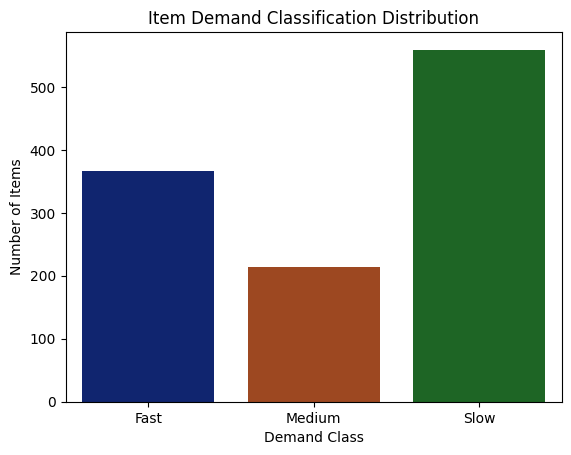

In [26]:
demand_class_dist = (
    item_summary
    .groupby("activity_class")
    .size()
    .reset_index(name="item_count")
)
sns.barplot(
    x="activity_class",
    y="item_count",
    data=demand_class_dist, palette="dark", hue="activity_class")
plt.title("Item Demand Classification Distribution")
plt.xlabel("Demand Class")
plt.ylabel("Number of Items")
plt.show()


In [27]:
demand_class_dist

,activity_class,item_count
0,Fast,366
1,Medium,214
2,Slow,559



 # Insight: Demand Classification Distribution

The demand classification shows that the dataset contains 1,139 distinct items, with demand behavior unevenly distributed across categories. Nearly half of the items (559, 49%) fall into the Slow category, indicating infrequent usage across the analysis period. In contrast, 366 items (32%) are classified as Fast-moving, reflecting consistent month-to-month demand, while the remaining 214 items (19%) belong to the Medium category with intermittent but observable usage.

This distribution reveals a clear long-tail demand structure, where consistent operational activity is driven by a relatively small subset of items, while the majority move irregularly. Fast-moving items, despite being a minority, represent the most stable and recurring demand, suggesting that regular service operations rely on a concentrated portion of the item catalog. The Medium category acts as a transitional group and does not dominate overall demand behavior.

From this output alone, it is evident that item demand is highly skewed and non-uniform, making uniform treatment of all items inappropriate. However, conclusions regarding revenue contribution, inventory adequacy, or the necessity of slow-moving items cannot be drawn without additional financial and stock-level analysis.

# Top Fast-Moving Items by Quantity
🔍 What this visualization shows

This chart ranks the most critical fast-moving items by total quantity issued over the analysis period.

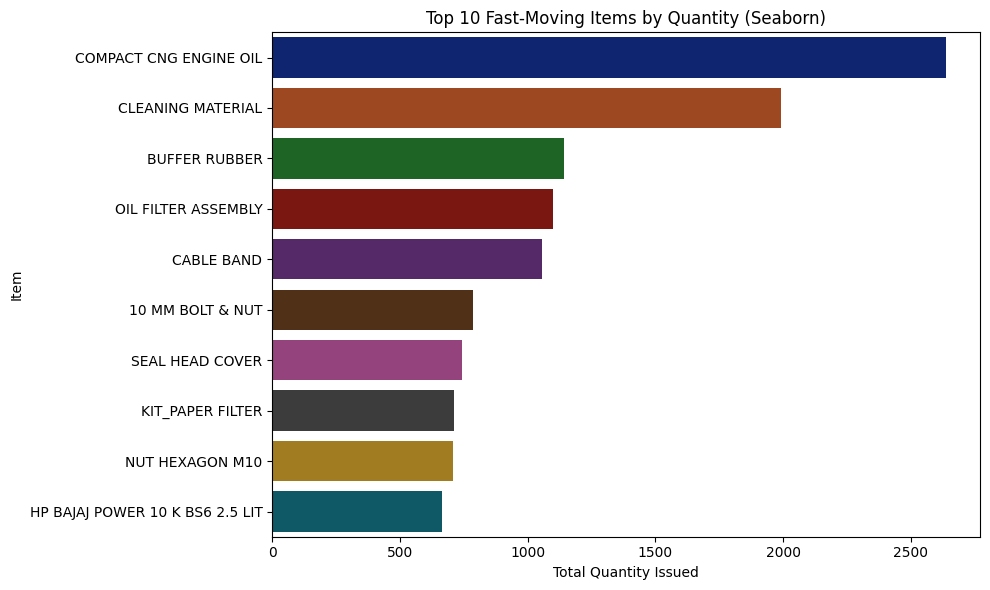

In [50]:
top_fast = (
    final_item_profile[
        final_item_profile["activity_class"] == "Fast"
    ]
    .sort_values("total_qty", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="total_qty",
    y="Item Name",
    data=top_fast,
    palette="dark",
    hue="Item Name",
    legend=False
)
plt.title("Top 10 Fast-Moving Items by Quantity (Seaborn)")
plt.xlabel("Total Quantity Issued")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

#Insights: High-Volume Fast-Moving Items with Demand Stability

This output highlights a subset of fast-moving items that are not only consistently active across all months (months_active = 7, activity_ratio = 1.0) but also exhibit high total quantities and invoice counts, confirming their sustained and recurring usage. Items such as COMPACT CNG ENGINE OIL, CLEANING MATERIAL, and OIL FILTER ASSEMBLY show very high invoice frequencies (over 1,000 invoices each), indicating frequent, repeated consumption rather than sporadic bulk usage.

Despite large differences in total quantity and total value across items, the coefficient of variation (CV) for most items remains below 0.35, suggesting relatively stable month-to-month demand. A few items, such as BUFFER RUBBER, show higher variability (CV ≈ 0.45), indicating less predictable consumption despite being fast-moving. This demonstrates that even within the Fast category, demand stability is not uniform.

Overall, the output shows that these items combine high operational importance (consistent monthly presence) with varying levels of demand predictability. This distinction is critical because it reveals that fast-moving status alone does not guarantee stable demand, and some frequently used items still experience noticeable fluctuations over time.

#Demand Volume vs Volatility (Scatter Plot)
🔍 What this visualization shows

This chart compares:

Total demand volume (how much is used)

Demand volatility (CV) (how unpredictable it is)

Each point represents an item.

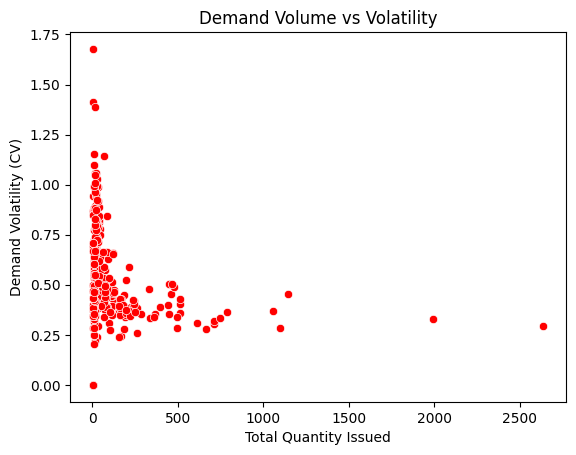

In [34]:
plt.figure()
sns.scatterplot(
    data=final_item_profile,
    x="total_qty",
    y="cv", color = "red"
)

plt.xlabel("Total Quantity Issued")
plt.ylabel("Demand Volatility (CV)")
plt.title("Demand Volume vs Volatility")
plt.show()


#Insights: Demand Volume vs Demand Volatility

The scatter plot shows a clear relationship between total quantity issued and demand volatility (CV) across items. A large concentration of items appears at low total quantities with high volatility, indicating that many low-volume items experience significant month-to-month fluctuations in demand. These items are scattered vertically, with CV values extending well above 1, reflecting highly irregular and unpredictable usage.

As total quantity increases, demand volatility generally declines and becomes more compressed, with most high-volume items clustering at lower CV values (approximately between 0.25 and 0.4). This suggests that items issued in larger quantities tend to have more stable and predictable demand patterns over time. However, the plot also shows that high demand volume does not completely eliminate variability, as some moderately high-volume items still exhibit noticeable volatility.

Overall, the visualization highlights a non-linear demand behavior, where predictability improves with scale but does not become uniform. It clearly distinguishes between low-volume, high-risk items and high-volume, relatively stable items, demonstrating that demand volume alone is insufficient to fully assess planning risk without considering volatility.

#Monthly Demand Trend (Overall)
🔍 What this visualization shows

This line chart tracks total spare-parts consumption over time.

In [43]:
monthly_trend = (
    item_month_demand
    .groupby("Year Month")
    .agg(total_qty=("total_qty", "sum"))
    .reset_index()
)

In [44]:
monthly_trend = monthly_trend[monthly_trend["Year Month"] != "2026-01"]

In [45]:
monthly_trend

,Year Month,total_qty
0,2025-07,6043.55
1,2025-08,5756.10
2,2025-09,5992.35
3,2025-10,5977.85
4,2025-11,5371.95
5,2025-12,6655.55


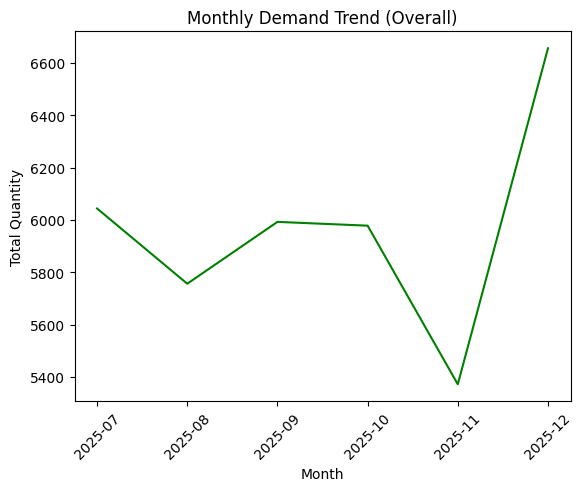

In [47]:
sns.lineplot(
    data=monthly_trend,
    x=monthly_trend["Year Month"].astype(str),
    y="total_qty", color = "green"
)
plt.xticks(rotation=45)
plt.title("Monthly Demand Trend (Overall)")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.show()

#Insights: Monthly Demand Trend (Overall)

The monthly demand trend shows noticeable variation in total quantity issued across the observed months rather than a flat or stable pattern. Demand starts at a relatively higher level, declines in the following month, then partially recovers before dropping sharply in the penultimate month. This dip is followed by a strong rebound in the final month, which records the highest total demand in the period.

This pattern indicates that overall demand is not uniform over time and experiences clear month-to-month fluctuations. The sharp decrease and subsequent surge suggest the presence of temporal effects, where demand can contract significantly in one period and expand rapidly in another. From the output alone, it is evident that relying on a single month as representative of typical demand would be misleading, as demand levels vary materially across months.

Overall, the trend confirms that spare-parts demand exhibits time-dependent variability, reinforcing the importance of analyzing demand over multiple periods rather than using static averages or isolated observations.

#Final Project Conclusion

Overall Conclusion
This project demonstrates how raw ERP billing data can be transformed into actionable operational intelligence for a spare-parts service business.
By separating demand behavior from revenue, handling real-world data anomalies, and applying demand stability concepts, the analysis provides a practical foundation for inventory prioritization, workload planning, and branch-level decision-making.

